In [1]:
import cabinetry

We start by configuring the output from `cabinetry`. It uses the `logging` module to send messages at different verbosity levels. This customization is optional, and you can also use the `logging` module directly for further customization. The `set_logging` function just sets up a verbose default.

In [2]:
cabinetry.set_logging()

## The configuration file

The configuration file is the central place to configure `cabinetry`.
Let's have a look at the example configuration file used in this notebook.

In [3]:
cabinetry_config = cabinetry.configuration.load("config_ntuples.yml")
cabinetry.configuration.print_overview(cabinetry_config)

INFO - cabinetry.configuration - opening config file config_ntuples.yml
INFO - cabinetry.configuration - the config contains:
INFO - cabinetry.configuration -   3 Sample(s)
INFO - cabinetry.configuration -   1 Regions(s)
INFO - cabinetry.configuration -   1 NormFactor(s)
INFO - cabinetry.configuration -   3 Systematic(s)


The configuration file is split into four different blocks of settings. There are general settings:

In [4]:
cabinetry_config["General"]

{'Measurement': 'minimal_example',
 'POI': 'Signal_norm',
 'HistogramFolder': 'histograms/',
 'InputPath': 'inputs/{SamplePath}'}

The list of phase space regions (channels), in this case we are considering just a single one:

In [5]:
cabinetry_config["Regions"]

[{'Name': 'Signal_region',
  'Variable': 'jet_pt',
  'Filter': 'lep_charge > 0',
  'Binning': [200, 300, 400, 500, 600]}]

A list of samples, including data:

In [6]:
cabinetry_config["Samples"]

[{'Name': 'Data',
  'Tree': 'pseudodata',
  'SamplePath': 'data.root',
  'Data': True},
 {'Name': 'Signal',
  'Tree': 'signal',
  'SamplePath': 'prediction.root',
  'Weight': 'weight'},
 {'Name': 'Background',
  'Tree': 'background',
  'SamplePath': 'prediction.root',
  'Weight': 'weight'}]

A list of normalization factors:

In [7]:
cabinetry_config["NormFactors"]

[{'Name': 'Signal_norm', 'Samples': 'Signal', 'Nominal': 1, 'Bounds': [0, 10]}]

And finally a list of systematic uncertainties. In this case there are three systematic uncertainties:

In [8]:
cabinetry_config["Systematics"]

[{'Name': 'Luminosity',
  'Up': {'Normalization': 0.05},
  'Down': {'Normalization': -0.05},
  'Type': 'Normalization'},
 {'Name': 'Modeling',
  'Up': {'SamplePath': 'prediction.root', 'Tree': 'background_varied'},
  'Down': {'Symmetrize': True},
  'Samples': 'Background',
  'Type': 'NormPlusShape'},
 {'Name': 'WeightBasedModeling',
  'Up': {'Weight': 'weight_up'},
  'Down': {'Weight': '0.7*weight'},
  'Samples': 'Background',
  'Type': 'NormPlusShape'}]

Regions, samples, normalization factors and systematics all can be identified by their names.

## Creating template histograms from ntuples

We use the `templates` module to create all histograms needed to build the workspace defined in the configuration file.

In [9]:
cabinetry.templates.build(cabinetry_config, method="uproot")

DEBUG - cabinetry.route -   in region Signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Data.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - Signal_region_Signal has empty bins: [0]
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Signal.npz
DEBUG - cabinetry.route -     reading sample Background
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Background.npz
DEBUG - cabinetry.route -       variation Modeling Up
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Background_Modeling_Up.npz
DEBUG - cabinetry.route -       variation WeightBasedModeling Up
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Background_WeightBasedModeling_Up.n

The histograms are saved to the folder specified under `HistogramFolder` in the `General` settings in the configuration file.
In this case, this folder is `histograms/`:

In [10]:
!ls histograms/

Signal_region_Background.npz
Signal_region_Background_Modeling_Up.npz
Signal_region_Background_WeightBasedModeling_Down.npz
Signal_region_Background_WeightBasedModeling_Up.npz
Signal_region_Data.npz
Signal_region_Signal.npz


It can be useful to apply additional post-processing after building template histograms.
Such processing can for example replace ill-defined statistical uncertainties in empty bins by zero.
It is also performed via the `templates` module:

In [11]:
cabinetry.templates.postprocess(cabinetry_config)

DEBUG - cabinetry.route -   in region Signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Data_modified.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - Signal_region_Signal has empty bins: [0]
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Signal_modified.npz
DEBUG - cabinetry.route -     reading sample Background
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Background_modified.npz
DEBUG - cabinetry.route -       variation Modeling Up
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Background_Modeling_Up_modified.npz
DEBUG - cabinetry.route -       variation WeightBasedModeling Up
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region

New histograms have now appeard in the `histograms/` folder.
These "modified" histograms include the changes applied by the postprocessor.

In [12]:
!ls histograms/

Signal_region_Background.npz
Signal_region_Background_Modeling_Up.npz
Signal_region_Background_Modeling_Up_modified.npz
Signal_region_Background_WeightBasedModeling_Down.npz
Signal_region_Background_WeightBasedModeling_Down_modified.npz
Signal_region_Background_WeightBasedModeling_Up.npz
Signal_region_Background_WeightBasedModeling_Up_modified.npz
Signal_region_Background_modified.npz
Signal_region_Data.npz
Signal_region_Data_modified.npz
Signal_region_Signal.npz
Signal_region_Signal_modified.npz


## Optional: reading existing template histograms

Besides providing ntuples that first need to be turned into histograms, it is also possible to provide existing histograms to `cabinetry`.
The configuration options for this are slightly different, since less information is needed to read an existing histogram.

The following loads a `cabinetry` configuration using histogram inputs, collects all provided histograms (storing them in the format used internally by `cabinetry` for further processing) and applies post-processing.
The resulting histograms are equivalent to those created when reading the provided ntuples.

In [13]:
cabinetry_config_histograms = cabinetry.configuration.load("config_histograms.yml")
cabinetry.templates.collect(cabinetry_config_histograms, method="uproot")
cabinetry.templates.postprocess(cabinetry_config)

INFO - cabinetry.configuration - opening config file config_histograms.yml
DEBUG - cabinetry.route -   in region Signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Data.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - Signal_region_Signal has empty bins: [0]
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Signal.npz
DEBUG - cabinetry.route -     reading sample Background
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Background.npz
DEBUG - cabinetry.route -       variation Modeling Up
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Background_Modeling_Up.npz
DEBUG - cabinetry.route -       variation WeightBasedModeling Up
DEBUG - cabinetry.histo - savin

## Workspace building

Next, we build a `pyhf` workspace and serialize it to a file.
The `workspace` module takes care of this task.

In [14]:
workspace_path = "workspaces/example_workspace.json"
ws = cabinetry.workspace.build(cabinetry_config)
cabinetry.workspace.save(ws, workspace_path)

INFO - cabinetry.workspace - building workspace
DEBUG - cabinetry.workspace - adding NormFactor Signal_norm to sample Signal in region Signal_region
DEBUG - cabinetry.workspace - adding OverallSys Luminosity to sample Signal in region Signal_region
DEBUG - cabinetry.workspace - adding OverallSys Luminosity to sample Background in region Signal_region
DEBUG - cabinetry.workspace - adding OverallSys and HistoSys Modeling to sample Background in region Signal_region
DEBUG - cabinetry.workspace - normalization impact of systematic Modeling on sample Background in region Signal_region is 0.800
DEBUG - cabinetry.workspace - adding OverallSys and HistoSys WeightBasedModeling to sample Background in region Signal_region
INFO - pyhf.workspace - Validating spec against schema: workspace.json
DEBUG - cabinetry.workspace - saving workspace to workspaces/example_workspace.json


## Fitting

With the workspace built, we can perform a maximum likelihood fit.
The fit model (probability density function) and data (including auxiliary data for auxiliary measurements, see the HistFactory documentation https://cds.cern.ch/record/1456844) are obtained from the workspace object.
The results for the fitted parameters are reported.
The `cabinetry.model_utils.model_and_data` function has an `asimov` keyword argument, which we can set to `True` to instead study the expected performance with an Asimov dataset.

In [15]:
bws = cabinetry.workspace.load(workspace_path)
model, data = cabinetry.model_utils.model_and_data(ws)
fit_results = cabinetry.fit.fit(model, data)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier staterror_Signal_region (4 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Signal_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Luminosity (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Modeling (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier WeightBasedModeling (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - MINUIT status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 17.19                      │              Nfcn = 327              │
│ EDM = 1.12e-06 (Goal: 0.0002)    │                                      │
├──────

We can also visualize the fit results.
Below are the pulls:

DEBUG - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


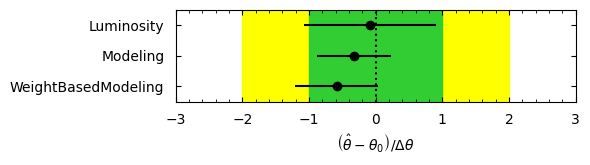

In [16]:
cabinetry.visualize.pulls(fit_results, exclude=["Signal_norm"])

We excluded the `"Signal_norm"` parameter, which does not have an associated constraint term in our fit model. The result for it was reported above in the fit output:
```
INFO - cabinetry.fit - Signal_norm                =  1.6895 +/- 0.9388
```
We can also look at the correlation between parameters:

DEBUG - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf


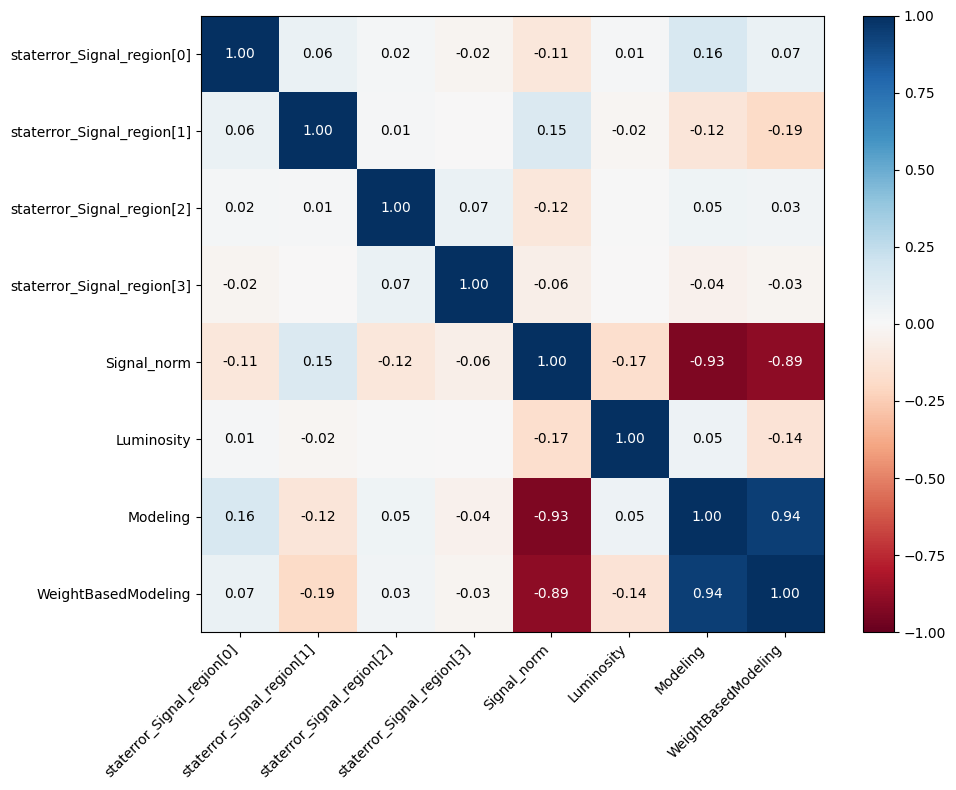

In [17]:
cabinetry.visualize.correlation_matrix(fit_results)

These visualizations were also saved as `.pdf` figures in the `figures/` folder.

## Visualizing templates

What did we fit?
The `visualize` module also contains functionality to plot data/MC distributions: `visualize.data_mc`.
We first need to create a model prediction, which is achieved with `model_utils.prediction`.
By default this creates the pre-fit model, but the optional `fit_results` argument allows to create the model corresponding to a given best-fit configuration.

The `config` keyword argument of `visualize.data_mc` is optional, but required for correct horizontal axis labels, since the observable and bin edges are not part of the `pyhf` workspace.
Since this argument is optional, you can use `cabinetry.visualize.data_mc` with any workspace: it does not matter whether it was created with `cabinetry` or otherwise, since you do not need a configuration file.

`visualize.data_mc` returns a list of dictionaries, we can extract a figure from there to further customize it.

DEBUG - cabinetry.model_utils - total stdev is [[69, 58.3, 38.2, 45.3]]
DEBUG - cabinetry.model_utils - total stdev per channel is [137]
DEBUG - cabinetry.visualize.utils - saving figure as figures/Signal_region_prefit.pdf


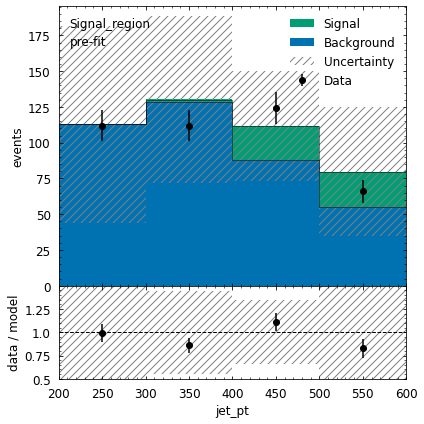

In [18]:
model_pred = cabinetry.model_utils.prediction(model)
figures = cabinetry.visualize.data_mc(model_pred, data, config=cabinetry_config)

This figure is also again saved in the `figures/` folder, like all figures in general.

To demonstrate figure customization, let's use $\LaTeX$ for the horizontal axis label. We can save the modified figure as well by using `.savefig()`.

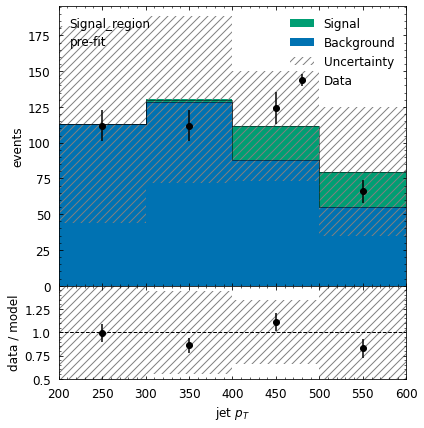

In [19]:
ratio_panel = figures[0]["figure"].get_axes()[1]
ratio_panel.set_xlabel("jet $p_T$")
figures[0]["figure"]  # show figure again

Yield tables can also be created from a model prediction, and compared to data. Optional keyword arguments control whether yields per bin are shown (`per_bin=True`, default) and whether bins summed per region are shown (`per_channel=True`, disabled by default).

In [20]:
cabinetry.tabulate.yields(model_pred, data)

INFO - cabinetry.tabulate - yields per bin for pre-fit model prediction:
╒════════════╤═════════════════╤════════════════╤════════════════╤═══════════════╕
│ sample     │ Signal_region   │                │                │               │
│            │ bin 1           │ bin 2          │ bin 3          │ bin 4         │
╞════════════╪═════════════════╪════════════════╪════════════════╪═══════════════╡
│ Background │ 112.74          │ 128.62         │ 88.11          │ 55.25         │
├────────────┼─────────────────┼────────────────┼────────────────┼───────────────┤
│ Signal     │ 0.00            │ 1.59           │ 23.62          │ 24.55         │
├────────────┼─────────────────┼────────────────┼────────────────┼───────────────┤
│ total      │ 112.74 ± 69.04  │ 130.21 ± 58.34 │ 111.72 ± 38.22 │ 79.79 ± 45.30 │
├────────────┼─────────────────┼────────────────┼────────────────┼───────────────┤
│ data       │ 112.00          │ 112.00         │ 124.00         │ 66.00         │
╘════════════╧

We can also take a look at the post-fit model.

DEBUG - cabinetry.model_utils - total stdev is [[11.9, 7.28, 7.41, 7.69]]
DEBUG - cabinetry.model_utils - total stdev per channel is [20.3]
DEBUG - cabinetry.visualize.utils - saving figure as figures/Signal_region_postfit.pdf


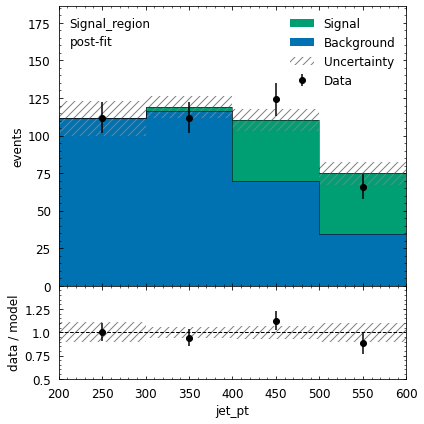

In [21]:
model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data, config=cabinetry_config)

## Beyond simple maximum likelihood fitting 

`cabinetry` provides a range of useful utilities for statistical inference besides simple maximum likelihood fitting.
To start, let's look at ranking nuisance parameters by their impact on the parameter of interest.

In [22]:
ranking_results = cabinetry.fit.ranking(model, data)

INFO - cabinetry.fit - MINUIT status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 17.19                      │              Nfcn = 327              │
│ EDM = 1.12e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 17.194205 at b

DEBUG - cabinetry.fit - -2 log(L) = 18.191510 at best-fit point
DEBUG - cabinetry.fit - POI is 1.828194, difference to nominal is 0.138661
INFO - cabinetry.fit - MINUIT status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 18.2                       │              Nfcn = 271              │
│ EDM = 6.06e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ 

DEBUG - cabinetry.fit - -2 log(L) = 18.192161 at best-fit point
DEBUG - cabinetry.fit - POI is 1.634683, difference to nominal is -0.054851
INFO - cabinetry.fit - MINUIT status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 18.2                       │              Nfcn = 286              │
│ EDM = 4.07e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │

DEBUG - cabinetry.fit - -2 log(L) = 19.481755 at best-fit point
DEBUG - cabinetry.fit - POI is 0.587180, difference to nominal is -1.102354
INFO - cabinetry.fit - MINUIT status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 18.23                      │              Nfcn = 245              │
│ EDM = 1.34e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │

The previous cell ran a lot of maximum likelihood fits to calculate all the input needed to rank nuisance parameters. We will visualize them next.

DEBUG - cabinetry.visualize.utils - saving figure as figures/ranking.pdf


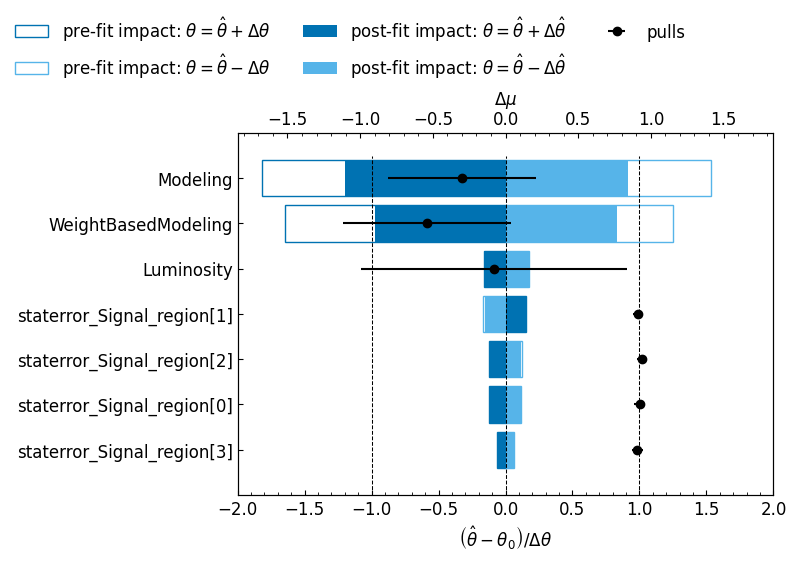

In [23]:
cabinetry.visualize.ranking(ranking_results)

The results are contained in the `ranking_results` object. It is a simple named tuple, we can have a look at its content.

In [24]:
ranking_results

RankingResults(bestfit=array([ 1.00102289,  0.98910429,  1.01970061,  0.98296235, -0.0880332 ,
       -0.32457146, -0.58582788]), uncertainty=array([0.04108182, 0.03792556, 0.03651561, 0.04250561, 0.99129049,
       0.55546394, 0.62721944]), labels=['staterror_Signal_region[0]', 'staterror_Signal_region[1]', 'staterror_Signal_region[2]', 'staterror_Signal_region[3]', 'Luminosity', 'Modeling', 'WeightBasedModeling'], prefit_up=array([-0.11067885,  0.14350015, -0.11311905, -0.05573699, -0.14964691,
       -1.67617185, -1.51531885]), prefit_down=array([ 0.10921275, -0.15331228,  0.11492629,  0.05864963,  0.16388633,
        1.41570164,  1.15001063]), postfit_up=array([-0.10774034,  0.13866119, -0.10800497, -0.05485057, -0.14842072,
       -1.10235359, -0.89696883]), postfit_down=array([ 0.10604542, -0.14383322,  0.10888302,  0.05779502,  0.16236051,
        0.84365887,  0.76572601]))

We can also perform likelihood scans for parameters.
The example below performs a scan for the `Modeling` nuisance parameter.

In [25]:
scan_results = cabinetry.fit.scan(model, data, "WeightBasedModeling")

INFO - cabinetry.fit - MINUIT status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 17.19                      │              Nfcn = 327              │
│ EDM = 1.12e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 17.194205 at b

DEBUG - cabinetry.fit - -2 log(L) = 17.354925 at best-fit point
DEBUG - cabinetry.fit - performing fit with WeightBasedModeling = -0.084
INFO - cabinetry.fit - MINUIT status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 17.86                      │              Nfcn = 170              │
│ EDM = 0.000185 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ No

The resulting figure looks like this:

DEBUG - cabinetry.visualize.utils - saving figure as figures/scan_WeightBasedModeling.pdf


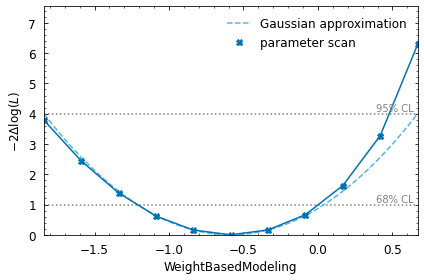

In [26]:
cabinetry.visualize.scan(scan_results)

With `cabinetry.fit.limit`, we can evaluate observed and expected 95% confidence level upper parameter limits.
The implementation uses Brent bracketing to efficiently find the `CLs=0.05` crossing points.

In [27]:
limit_results = cabinetry.fit.limit(model, data)

INFO - cabinetry.fit - calculating upper limit for Signal_norm
DEBUG - cabinetry.fit - setting lower parameter bound for POI to 0
INFO - cabinetry.fit - determining observed upper limit
DEBUG - cabinetry.fit - Signal_norm = 0.1000, observed CLs = 0.9176
DEBUG - cabinetry.fit - Signal_norm = 10.0000, observed CLs = 0.0000
DEBUG - cabinetry.fit - Signal_norm = 9.4606, observed CLs = 0.0000
DEBUG - cabinetry.fit - Signal_norm = 4.7803, observed CLs = 0.0001
DEBUG - cabinetry.fit - Signal_norm = 2.4401, observed CLs = 0.2174
DEBUG - cabinetry.fit - Signal_norm = 4.2427, observed CLs = 0.0012
DEBUG - cabinetry.fit - Signal_norm = 3.3414, observed CLs = 0.0302
DEBUG - cabinetry.fit - Signal_norm = 2.8908, observed CLs = 0.0935
DEBUG - cabinetry.fit - Signal_norm = 3.2002, observed CLs = 0.0444
DEBUG - cabinetry.fit - Signal_norm = 3.1514, observed CLs = 0.0504
DEBUG - cabinetry.fit - Signal_norm = 3.1564, observed CLs = 0.0498
INFO - cabinetry.fit - successfully converged after 11 steps
INFO

Again, the results are visualized:

DEBUG - cabinetry.visualize.utils - saving figure as figures/limit.pdf


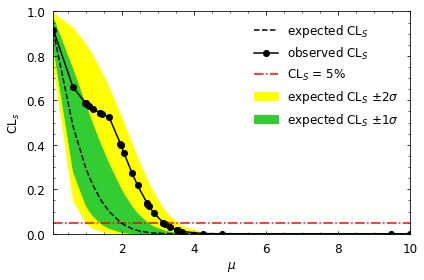

In [28]:
cabinetry.visualize.limit(limit_results)

The observed limits are above the expected limits.
We can calculate the discovery significance with `cabinetry.fit.significance`:

In [29]:
significance_results = cabinetry.fit.significance(model, data)

INFO - cabinetry.fit - calculating discovery significance
INFO - cabinetry.fit - observed p-value: 3.584%
INFO - cabinetry.fit - observed significance: 1.801
INFO - cabinetry.fit - expected p-value: 14.775%
INFO - cabinetry.fit - expected significance: 1.046


In this case, we observe a 1.8 sigma excess (and expected 1.0 sigma).